
### 01 - Data Exploration
![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

In [8]:
# Load data and Explore Classes
# ===================================================================

ds, info = tfds.load('malaria', split='train', shuffle_files=True, with_info=True)
print("Num classes: " + str(info.features['label'].num_classes))
print("Class names: " + str(info.features['label'].names))

Num classes: 2
Class names: ['parasitized', 'uninfected']


2024-05-11 13:29:57.952151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


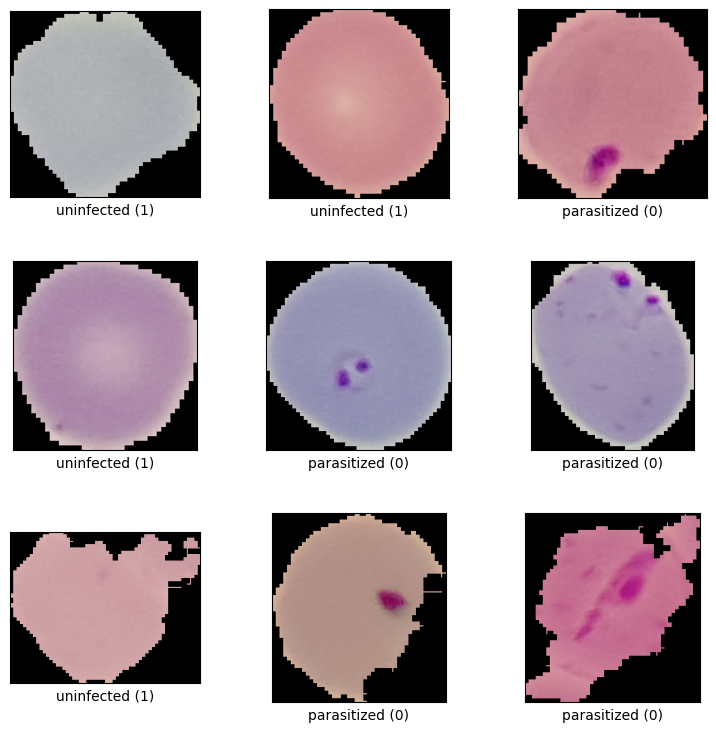

In [9]:
# Visualize Data
# ===================================================================

vis = tfds.visualization.show_examples(ds, info)